In [1]:
# For tracking changes in data generated through script and GEE attribution dataset
Dataset_version = 1
GEE_data_version = 0
Python_script_version = 0
Year = '(2001-2022)'

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load the feature collection needed to simulate aggregation
df_geometry = pd.read_csv("/home/chandra/backup/Chalmers/GADM_Boundaries.csv")

# Sample dataframe
# Groupby and count
counts = df_geometry.groupby('COUNTRY').size().reset_index(name='count')

# Resulting dataframe with distinct values and count of each value
result = pd.DataFrame(counts[['COUNTRY', 'count']]).sort_values(by='COUNTRY')#, ascending=False)
#result[0:20]
#result


In [5]:
result['COUNTRY'].values

array(['Afghanistan', 'Akrotiri and Dhekelia', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire, Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil',
       'British Indian Ocean Territory', 'British Virgin Islands',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Canada', 'Caspian Sea', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Clipperton Island', 'Cocos Islands',
       'Colombia', 'Comoros', 'Cook Islands', 'Costa Rica', 'Croatia',
       'Cuba', 'Curaçao', 'Cyprus', 'Czechia', "Côte d'Ivoire",
       'Democratic Republic of the Congo', 'Denmar

In [6]:
def find_forest_loss_files(Country):
    directory_path = '/home/chandra/backup/Chalmers/DeDuCE v'+str(Dataset_version)+'.'+str(GEE_data_version)+'.'+str(Python_script_version)+' ' + Year+'/DeDuCE_dataset_GEE'
    
    # Addressing special character in country names
    if Country == 'Åland':
        Country = 'Aland'
    if Country =='Côte d\'Ivoire':
        Country = 'Cote dIvoire'
    if Country == 'Curaçao':
        Country = 'Curacao'
    if Country == 'México':
        Country = 'Mexico'
    if Country == 'Réunion':
        Country = 'Reunion'
    if Country == 'Saint-Barthélemy':
        Country = 'Saint-Barthelemy'
    if Country == 'São Tomé and Príncipe':
        Country = 'Sao Tome and Principe'

    # Searches for forest loss files for the specified countries in the directory and merges the data across rows
    classification_files = []    
    classification_file_pattern = 'Forest_loss_to_CLASSIFICATION_' + str(Country) + '_'
        
    # Get a list of all the matching file paths
    FLC_file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if classification_file_pattern in f]

    # The code will show an error when multiple files are read for the same category
    if len(FLC_file_paths) > 1:
        print('\033[91m' + 'Multiple forest loss attribution files for the same country' + '\033[0m')
        
    try:
        classification_file = pd.read_csv(FLC_file_paths[0])
    except pd.errors.EmptyDataError:    
        return None
    # Merge the data across rows
    #merged_classification = pd.concat(classification_files, ignore_index=True)
    #return classification and AGB/BGB files
    return classification_file

In [38]:
def visualise_attribution(Forest_loss_attributed, Country):
    global df, color_values
    df = (Forest_loss_attributed.groupby(['COUNTRY', 'Class']).sum().reset_index()[['COUNTRY', 'Class'] \
                            + [f'loss_{year}' for year in range(2001, 2023)]]).iloc[:,1:]
    df.set_index('Class', inplace=True)
    df = df.sort_index(ascending=False)

    # Get the index values between -100 and 2100
    custom_index = sorted(list(set(df.index).intersection(range(-2100, -1299))))

    # Get the remaining index values
    remaining_index = sorted(list(set(df.index).difference(custom_index)))
    remaining_index.sort(reverse=True)
    # Concatenate the two lists of index values
    new_index = remaining_index+custom_index

    # Reindex the dataframe using the new index
    df = df.reindex(new_index)

    color = pd.read_excel('/home/chandra/backup/Chalmers/DeDuCE v'+str(Dataset_version)+'.'+str(GEE_data_version)+'.'+str(Python_script_version)+' ' + 
                          Year+'/Supplementary_data-DeDuCE v1.xlsx', sheet_name = 'Color scheme')

    color_values = []
    #"""
    for i in df.index:
        #print(i, ':', color[color['Re-classification code'] == i]['Color'].values[0])
        color_values.append(color[color['Re-classification code'] == i]['Color'].values[0])
    """
    for i in df.index:
        if i < 0:
            color_values.append('#bdbdbd')
        else:
            color_values.append('#5ab4ac')
    """

    import matplotlib.ticker as ticker

    fig, ax1 = plt.subplots(figsize = (10,4), dpi = 300)

    # List of colors for each bar
    bottom = 0
    # Create the plot
    for i in range(len(df)):
        if df.index[i] < 0:
            opacity = 0.45
            hatch = ''
            if (df.index[i] <= -100) & (df.index[i] >= -2100):
               hatch = '///'
        else: 
            opacity = 0.9
            hatch = ''
        if i == 0:
            ax1.bar(range(2001, 2000+len(df.iloc[i])+1), df.iloc[i], color = color_values[i], alpha = opacity, width = 0.80, hatch = hatch)
            bottom = df.iloc[i]
            continue
        ax1.bar(range(2001, 2000+len(df.iloc[i])+1), df.iloc[i], bottom=bottom, color = color_values[i], alpha = opacity, width = 0.80, hatch = hatch)
        bottom = bottom+df.iloc[i]

    df_forest_loss = (Forest_loss_attributed.groupby(['COUNTRY']).sum().reset_index()[['COUNTRY'] + [f'loss_{year}' for year in range(2001, 2023)]]).iloc[:,1:] 
    ax1.bar(range(2001, 2000+len(df_forest_loss.iloc[0])+1), df_forest_loss.iloc[0], edgecolor="black", linewidth=0.05, facecolor = 'None', width = 0.80)
    ax1.step(range(2000, 2000+len(df_forest_loss.iloc[0])+2), np.append(np.append(df_forest_loss.iloc[0].values[0], df_forest_loss.iloc[0].values), 
                                                                        df_forest_loss.iloc[0].values[-1]), linewidth=1.5, color="k",where="mid", zorder = 10, ls = '--')

    old_sum = (df[df.index >= 0].sum()).values
    old_sum = np.append(np.append(old_sum[0], old_sum), old_sum[-1])

    ax1.step(range(2000, 2000+len(df_forest_loss.iloc[0])+2), old_sum, linewidth=1.5, color="k",where="mid", zorder = 15)
    ax1.legend(loc="upper left", bbox_to_anchor=(1,1))

    ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax1.tick_params(axis='both', which='major', labelsize=15, width=1.5, length=6)

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_xlim(2000.4,)

    import matplotlib.patches as mpatches

    patch = {}
    patches = []
    for i in range(len(color_values)):
        patch[i] = mpatches.Patch(color=color_values[i], label=df.index[i])

    for i in range(len(color_values)):
        patches.append(patch[i])

    # Define the formatting function
    def millions_formatter(x, pos):
        return '{:.0f}k ha'.format(x / 1000)

    # Setting the number of ticks
    ax1.set_xticks([2001, 2005, 2010, 2015, 2020])
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

    # change all spines
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(1.5)
    ax1.set_title(Country, fontsize = 15)
    ax1.legend(handles=patches, loc="upper left", bbox_to_anchor=(1,1), ncol=4, fontsize = '5')
    ax1.set_ylabel('Deforestation', fontsize = 15)

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


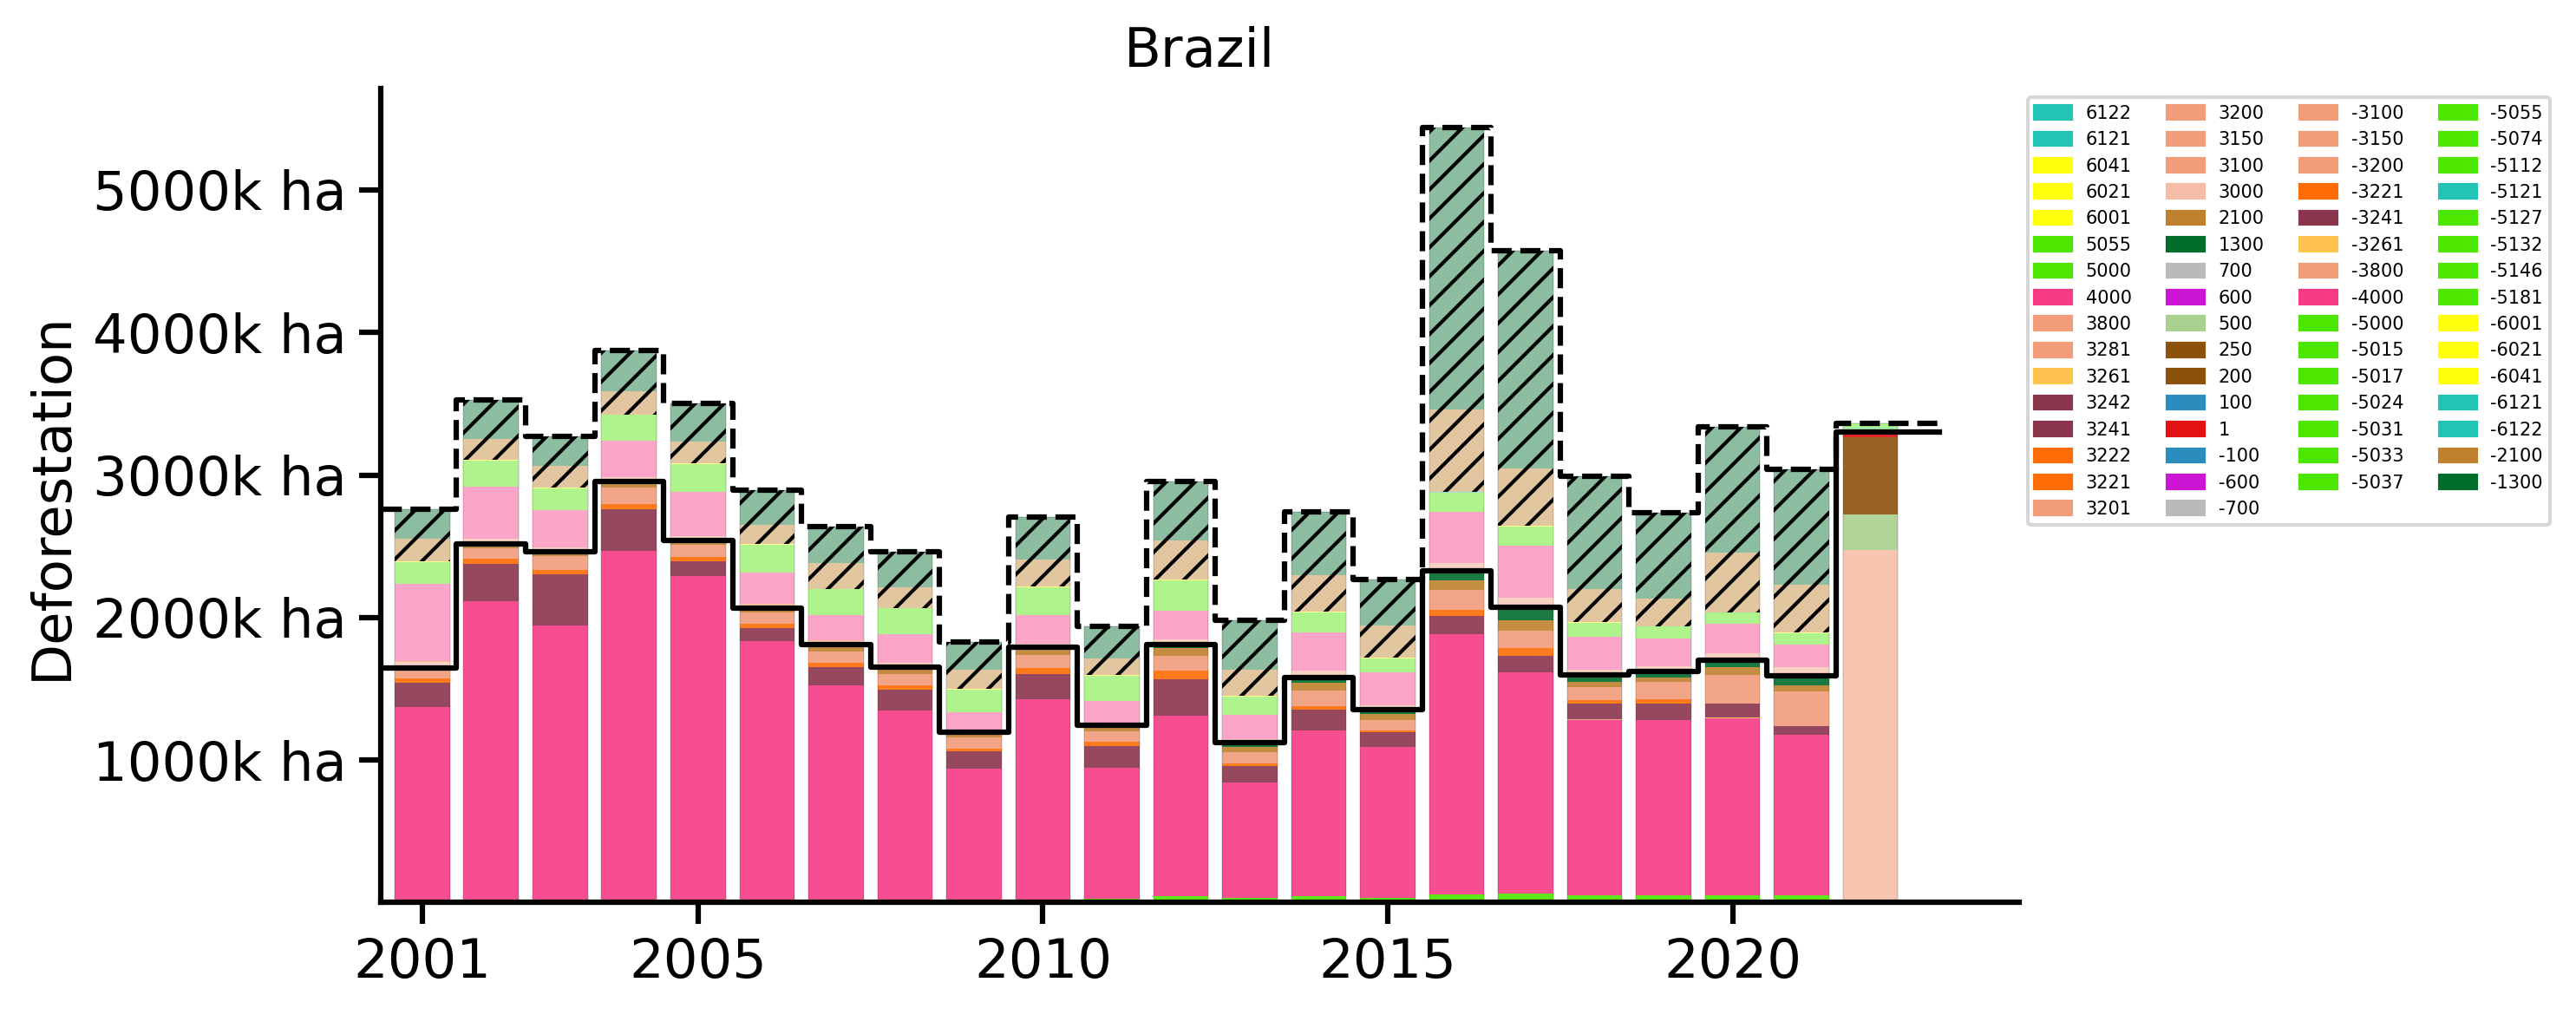

In [39]:
for Country in ['Brazil']:
    #print(Country)
    if Country in ['Greenland']:
        continue
    Forest_loss_attributed = find_forest_loss_files(Country)
    if Forest_loss_attributed is None:
        continue  # Skip to the next country        
    else:
        visualise_attribution(Forest_loss_attributed, Country)
